# Assignment A7: Bayesian Classification

### CS 6640
### Fall 2018

**By:** Cade Parkison


---

You are to develop a vehicle pattern recognition function based on the optimal Bayes classifier.
Using the videos found in the CS6640 class data sub-directory A7, select the first
2 (i.e., < X > 1 and < X > 2) for the three classes, bus, car, and truck, to get training
vectors with suitable features, and then build Bayes models and evaluate those models on
the remaining videos (i.e., classify the vehicles in each frame). Carefully describe each step
of the process; data collection, feature selection and computation, model choice, training
results, and evaluation. Implement the requested two functions.

Bayes Classifier:

In [5]:
%%file CS6640_Bayes.m
function best_class = CS6640_Bayes(x,class_probs,class_models)
% CS6640_Bayes - Bayes classifier
% On input:
%     x (mx1 vector): feature vector
%     class_probs (1xn vector): probabilities of n classes (sums to 1)
%     class_models (1xn vector struct): class models: means and
%     variances
%       (k).mean (mx1 vector): k_th class mean vector
%       (k).var (mxm array): k_th class covariance matrix
% On output:
%     best_class (int): index of best class for x
% Call:
%     c = CS6640_Bayes(x,cp,cm);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%


Created file 'C:\Users\cadep\School\CS_6640\A7\CS6640_Bayes.m'.


Build Bayes Model:

In [6]:
%%file CS6640_build_Bayes.m
function model = CS6640_build_Bayes(X)
% CS6640_build_Bayes - build Bayes model for dataset X
% On input:
%     X (nxm array): n samples of m-tuple feature vectors
% On output:
%     model (struct): model: mean and variance
%       .mean (mx1 vector): mean of X
%       .var (mxm array): covariance matrix of X
% Call:
%     m1 = CS6640_build_Bayes([0,0; 0.1,0; -0.1,0]);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%


Created file 'C:\Users\cadep\School\CS_6640\A7\CS6640_build_Bayes.m'.


---
#### Testing

In [2]:
format compact

In [22]:
clear all;close all;clc

In [23]:
car1 = VideoReader('car1.avi');
car2 = VideoReader('car2.avi');

bus1 = VideoReader('bus1.avi');
bus2 = VideoReader('bus2.avi');

truck1 = VideoReader('truck1.avi');
truck2 = VideoReader('truck2.avi');

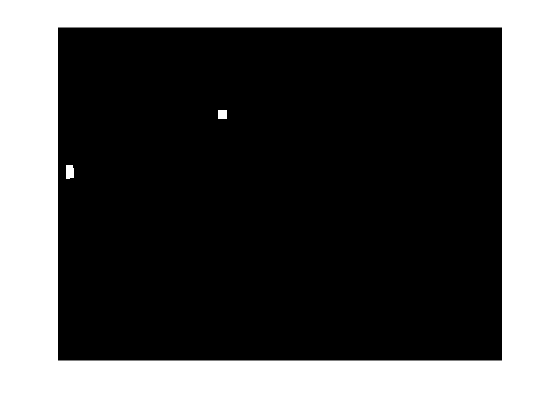

In [24]:
M1 = CS6640_MM(car2);

In [25]:
implay(M1)

In [29]:
M = M1;
[m,n, r] = size(M(1).cdata);
n_frames = length(M);

ims = zeros(m,n,n_frames);

In [ ]:
for i=1:n_frames
    bw = im2bw(M(k).cdata);

    % Get segmented region with largest size
    [L,n_regions] = bwlabel(bw);
    region_size = zeros(n_regions,1);
    for r=1:n_regions
        region_size(r) =  length(find(L==r));
    end
    [max_, I] = max(region_size);
    bw = L==I;
    
    im_seg(:,:,k) = bw;
    
    
end